In [1]:
import wrds
import pandas as pd
import numpy as np
from scipy import stats
import scipy.linalg as la
from scipy.integrate import quad
from sklearn.metrics import make_scorer
from sklearn import linear_model
from sklearn import model_selection
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
#from statsmodels.regression.rolling import RollingOLS
#import linearmodels as lm
exec(open("/home/amz5/functionsByAnthony.py").read()) # do whatever is in functionsByAnthony.py
from statsmodels.iolib.summary2 import summary_col
import os
wd=os.getcwd()
import random
import warnings

## Part 1 - No Skilled Funds

In [2]:
## Generating Time Series of Market returns (mkt_ts)
T=120
mu_rmktann=5
sigma_rmktann=20

np.random.seed(2021)

mkt_ts=np.random.normal(mu_rmktann/12,sigma_rmktann/np.sqrt(12),(T))

## Generating Time Series of Residuals (sig_ts)
#Changed from 30 to 10 following canvas announcement
res_vol_ann=10
N=1000
sig_ts=np.random.normal(0,res_vol_ann/np.sqrt(12),(N,T))

## Adding residuals to market returns to generate fund returns if alpha_i=0 for each fund
fundrets=sig_ts+mkt_ts

In [3]:
#Estimating each fund's alpha, t-statistic_alpha, beta, and residuals  
betas=[]
alphas=[]
tstats=[]
residuals=pd.DataFrame()
for n in range(0,N): 
    reg=sm.OLS(fundrets[n], sm.add_constant(mkt_ts)).fit()
    tstats.append(reg.tvalues[0])
    alphas.append(reg.params[0])
    betas.append(reg.params[1])
    residuals=residuals.append(pd.DataFrame(reg.resid).T)
tstats=np.array(tstats)
alphas=np.array(alphas)
betas=np.array(betas)
residuals=residuals.reset_index().drop(columns='index')

In [4]:
random.randint(0, 119)

92

In [5]:
## The 'bullet' functions below refer to the 3 bullets given in the assignment:
###      -Draw a bootstrap sample of 120 months from the T = 1, 2, ..., 120 months (with replacement).
###      -For each fund, construct a bootstrap time-series of zero-skill excess returns r using the sampled 
###       market return and residual
###      -Estimate the market model regression using the bootstrap time-series of r to obtain bootstrapped estimates of
###       alphas and their tstats

## Function to create a time-series of T=120 observations, where each observation is drawn with replacement from
## [0,119].  This time-series is indexed to the time series of simulated data from above
def bullet1():
    random_list = []
    for i in range(0, 120):
        #print(i)
        random_list.append(random.randint(0, 119))
    return random_list

In [6]:
## returns a simulated (panel) dataframe of zero-skill excess returns and timeseries of corresponding mkt returns
def bullet2():
    ind=bullet1()
##constructing zero-skill excess returns
    zskillrets=pd.DataFrame(np.nan,index=range(0,N), columns=range(0,120))
    mkt=pd.DataFrame(np.nan,index=range(0,120), columns=["mkt"])
    for i in range(0, 120):
        j=ind[i]
        for n in range(0,N): 
            zskillrets.iloc[n][i]=betas[n]*mkt_ts[j]+residuals.iloc[n][j]
        mkt.iloc[i]=mkt_ts[j]
    return zskillrets, mkt

In [7]:
def bullet3():
    simrets, simmkt=bullet2()
#Estimating each fund's (simulated) alpha, t-statistic_alpha  
    sim_alphas=[]
    sim_tstats=[]
    for n in range(0,N): 
        reg=sm.OLS(simrets.iloc[n], sm.add_constant(simmkt)).fit()
        sim_tstats.append(reg.tvalues[0])
        sim_alphas.append(reg.params[0])
    sim_tstats=np.array(sim_tstats)
    sim_alphas=np.array(sim_alphas)
    return sim_tstats, sim_alphas

In [8]:
############
### Now, performing the 3 bullets outlined above B times, and saving the resulting tstats and alphas
### to tB and alphaB
############
warnings.filterwarnings('ignore')

B=100
tB=pd.DataFrame()
alphaB=pd.DataFrame()
for b in range(0,B):
    sim_tstats, sim_alphas=bullet3()
    tB=pd.concat([tB, pd.DataFrame(sim_tstats, columns=[b])], axis=1)
    alphaB=pd.concat([alphaB, pd.DataFrame(sim_alphas, columns=[b])], axis=1)

In [9]:
## Create a parallel dataframe to tB that consists of ranks (1-1000) in each bootstrap run.
## ie the i,jth entry in tbRank is the rank of the i,jth entry of tB in the jth boostrap run
## 1000 is the highest tstat, 0 the lowest.

In [10]:
tBrank=pd.DataFrame()
for b in range(0,B):
    tBrank[b]=tB[b].rank()

tBrankmn=pd.DataFrame(index=[1,2], columns=range(1,1001))
##Finding the average tstate for each rank, r=1...1000,
## reporting this in table tavgrank
for r in range(1,1001):
    tBrankmn.iloc[0][r]=((tBrank==r)*(tB)).max().mean()
    tBrankmn.iloc[1][r]=((tBrank==r)*(tB)).min().mean()
tavgrank=pd.DataFrame(tBrankmn.sum()).rename(columns={0:'Tstat'})#>0

In [11]:
tavgrank=tavgrank.reset_index().rename(columns={"index":"Rank"})

In [12]:
ct5=(5/100)*N
ct95=(95/100)*N
p5s=[]
p95s=[]
for b in range(0,B):
    p5=tB[(tBrank[b]==ct5)][b].mean()
    p95=tB[(tBrank[b]==ct95)][b].mean()
    p5s.append(p5)
    p95s.append(p95)

In [60]:
ptiles=pd.DataFrame([round(tavgrank[tavgrank["Rank"]==1000*.95]["Tstat"][1000*.95-1],2),
              round(tavgrank[tavgrank["Rank"]==1000*.05]["Tstat"][1000*.05-1],2)]).T.rename(columns={0:'95th Percentile', 1:'5th Percentile'})

In [68]:
tavgrank

,Rank,Tstat
,1,-3.119126
,2,-2.876371
,3,-2.741904
,4,-2.644862
,5,-2.567854
...,...,...
,996,2.577962
,997,2.660938
,998,2.747389
,999,2.911814


In [14]:
tstatsdf=pd.DataFrame(tstats,columns=["estT"])
tstatsdf["rank"]=tstatsdf["estT"].rank()

In [15]:
tstatsdf=tstatsdf.sort_values(by="rank")

Text(0, 0.5, 'Cumulative Distribution')

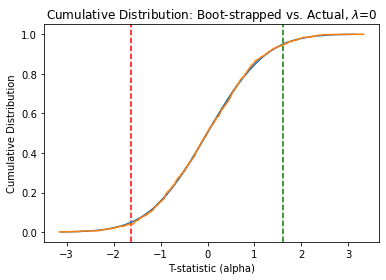

In [81]:
plot1=plt.figure()
X  = tavgrank["Tstat"]#np.arange(tavgrank.min()["Tstat"], tavgrank.max()["Tstat"], dx)
# Normalize the data to a proper PDF
Y = tavgrank["Rank"]/1000
plt.axvline(x=tavgrank[tavgrank["Rank"]==ct5]["Tstat"].mean(), color='r', linestyle='--')
plt.axvline(x=tavgrank[tavgrank["Rank"]==ct95]["Tstat"].mean(), color='g', linestyle='--')

plt.plot(X, Y)

Xact  = tstatsdf["estT"]#np.arange(tavgrank.min()["Tstat"], tavgrank.max()["Tstat"], dx)
# Normalize the data to a proper PDF
Yact = tstatsdf["rank"]/1000
plt.plot(Xact, Yact)
plt.title("Cumulative Distribution: Boot-strapped vs. Actual, "+"$\\lambda$=0")
plt.xlabel('T-statistic (alpha)')
plt.ylabel('Cumulative Distribution')


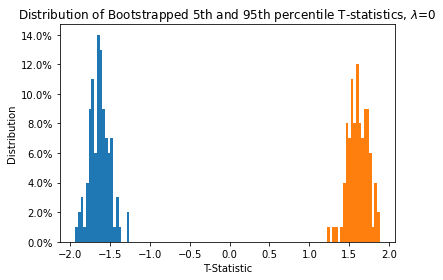

In [76]:
from matplotlib.ticker import PercentFormatter
## Plotting distribution of 5th and 95th percentiles
plot2=plt.figure()

plt.hist(p5s, bins=20, weights=np.ones(len(p5s)) / len(p5s))
plt.hist(p95s, bins=20, weights=np.ones(len(p95s)) / len(p95s))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("T-Statistic")
plt.ylabel("Distribution")
plt.title("Distribution of Bootstrapped 5th and 95th percentile T-statistics, $\\lambda$=0")

plt.show()

## Part 2 - Some Skilled Funds

I will simulate skilled funds by adding the appropriate $\alpha$ to the simulated returns in the previous part.

In [18]:
# Creating a function to find alphas, tstats, pvalues for each fund, given a proportion of skilled funds, llambda
def pre_plot(llambda, alpha_yr):
    fundretsnew=fundrets.copy()
    #changed from 2.5 to 5 following canvas announcement
    alpha_mth=alpha_yr/12
    for n in range(0,int(N*llambda)): 
        fundretsnew[n]=fundrets[n]+alpha_mth
    
#Estimating each fund's alpha, t-statistic_alpha, beta, and residuals  
    betas=[]
    alphas=[]
    tstats=[]
    residuals=pd.DataFrame()
    lam=[llambda]*N
    a=[alpha_yr]*N
    for n in range(0,N): 
        reg=sm.OLS(fundretsnew[n], sm.add_constant(mkt_ts)).fit()
        tstats.append(reg.tvalues[0])
        alphas.append(reg.params[0])
        betas.append(reg.params[1])
        residuals=residuals.append(pd.DataFrame(reg.resid).T)
    tstats=np.array(tstats)
    alphas=np.array(alphas)
    betas=np.array(betas)
    lam=np.array(lam)
    
    return tstats, alphas, betas, residuals, fundretsnew

In [19]:
def fullBot(llambda, alpha_yr):
    tstats,alphas,betas,residuals, fundretsnew=pre_plot(llambda, alpha_yr)
############
### Now, performing the 3 bullets outlined above B times, and saving the resulting tstats and alphas
### to tB and alphaB
############
    warnings.filterwarnings('ignore')
    
    B=100
    tB=pd.DataFrame()
    alphaB=pd.DataFrame()
    for b in range(0,B):
        sim_tstats, sim_alphas=bullet3()
        tB=pd.concat([tB, pd.DataFrame(sim_tstats, columns=[b])], axis=1)
        alphaB=pd.concat([alphaB, pd.DataFrame(sim_alphas, columns=[b])], axis=1)
    
    tBrank=pd.DataFrame()
    for b in range(0,B):
        tBrank[b]=tB[b].rank()

    tBrankmn=pd.DataFrame(index=[1,2], columns=range(1,1001))
##Finding the average tstate for each rank, r=1...1000,
## reporting this in table tavgrank
    for r in range(1,1001):
        tBrankmn.iloc[0][r]=((tBrank==r)*(tB)).max().mean()
        tBrankmn.iloc[1][r]=((tBrank==r)*(tB)).min().mean()
    tavgrank=pd.DataFrame(tBrankmn.sum()).rename(columns={0:'Tstat'})#>0

    tavgrank=tavgrank.reset_index().rename(columns={"index":"Rank"})
    ct5=(5/100)*N
    ct95=(95/100)*N
    p5s=[]
    p95s=[]
    for b in range(0,B):
        p5=tB[(tBrank[b]==ct5)][b].mean()
        p95=tB[(tBrank[b]==ct95)][b].mean()
        p5s.append(p5)
        p95s.append(p95)
    
    tstatsdf=pd.DataFrame(tstats,columns=["estT"])
    tstatsdf["rank"]=tstatsdf["estT"].rank()
    tstatsdf=tstatsdf.sort_values(by="rank")
    
    return tavgrank, tstatsdf, p5s, p95s

In [26]:
def plotr(lamm):
    a1tavgrank, a1tstatsdf, a1p5s, a1p95s=fullBot(lamm, 1)
    a2tavgrank, a2tstatsdf, a2p5s, a2p95s=fullBot(lamm, 2.5)
    a3tavgrank, a3tstatsdf, a3p5s, a3p95s=fullBot(lamm, 5)
    bylam=plt.figure()
## first stacked plot fo 3 alphas    
    ax1=plt.subplot(311) 
    X  = a1tavgrank["Tstat"]
    Y = a1tavgrank["Rank"]/1000
    plt.axvline(x=a1tavgrank[a1tavgrank["Rank"]==ct5]["Tstat"].mean(), color='r', linestyle='--')
    plt.axvline(x=a1tavgrank[a1tavgrank["Rank"]==ct95]["Tstat"].mean(), color='g', linestyle='--')
    plt.plot(X, Y)

    Xact  = a1tstatsdf["estT"]#np.arange(tavgrank.min()["Tstat"], tavgrank.max()["Tstat"], dx)
    Yact = a1tstatsdf["rank"]/1000
    plt.plot(Xact, Yact)
    ax1.set_title('$\\alpha = 1\%$',x=.1, y=.9, pad=-14)
    

    ax2=plt.subplot(312, sharey=ax1, sharex=ax1) # index 2
    X  = a2tavgrank["Tstat"]
    Y = a2tavgrank["Rank"]/1000
    plt.axvline(x=a2tavgrank[a2tavgrank["Rank"]==ct5]["Tstat"].mean(), color='r', linestyle='--')
    plt.axvline(x=a2tavgrank[a2tavgrank["Rank"]==ct95]["Tstat"].mean(), color='g', linestyle='--')
    plt.plot(X, Y)

    Xact  = a2tstatsdf["estT"]#np.arange(tavgrank.min()["Tstat"], tavgrank.max()["Tstat"], dx)
    Yact = a2tstatsdf["rank"]/1000
    plt.plot(Xact, Yact)
    ax2.set_title('$\\alpha = 2.5\%$',x=.1, y=.9, pad=-14)
    ax2.set_ylabel('Cumulative Probability')

    ax3=plt.subplot(313, sharey=ax1, sharex=ax1) # index 2
    X  = a3tavgrank["Tstat"]
    Y = a3tavgrank["Rank"]/1000
    plt.axvline(x=a3tavgrank[a3tavgrank["Rank"]==ct5]["Tstat"].mean(), color='r', linestyle='--')
    plt.axvline(x=a3tavgrank[a3tavgrank["Rank"]==ct95]["Tstat"].mean(), color='g', linestyle='--')
    plt.plot(X, Y)

    Xact  = a3tstatsdf["estT"]#np.arange(tavgrank.min()["Tstat"], tavgrank.max()["Tstat"], dx)
    Yact = a3tstatsdf["rank"]/1000
    plt.plot(Xact, Yact)
    ax3.set_title('$\\alpha = 5\%$',x=.1, y=.9, pad=-14)
    ax3.set_xlabel('T-statistic (alpha)')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle("Cumulative Distribution: Boot-strapped vs. Actual, "+"Lambda="+str(lamm))

    bylam.set_size_inches(12,(10/3)*2)
    plt.close()
## Second stacked plot of 3 alphas
    bylam2=plt.figure()

    ax1=plt.subplot(311) 
    plt.hist(a1p5s, bins=20, weights=np.ones(len(a1p5s)) / len(a1p5s))
    plt.hist(a1p95s, bins=20, weights=np.ones(len(a1p95s)) / len(a1p95s))
    ax1.set_title('$\\alpha = 1\%$',x=.5, y=.9, pad=-14)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    ax2=plt.subplot(312, sharey=ax1, sharex=ax1) # index 2
    plt.hist(a2p5s, bins=20, weights=np.ones(len(a2p5s)) / len(a2p5s))
    plt.hist(a2p95s, bins=20, weights=np.ones(len(a2p95s)) / len(a2p95s))
    ax2.set_title('$\\alpha = 2.5\%$',x=.5, y=.9, pad=-14)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    ax3=plt.subplot(313, sharey=ax1, sharex=ax1) # index 2
    plt.hist(a3p5s, bins=20, weights=np.ones(len(a3p5s)) / len(a3p5s))
    plt.hist(a3p95s, bins=20, weights=np.ones(len(a3p95s)) / len(a3p95s))
    ax3.set_title('$\\alpha = 5\%$',x=.5, y=.9, pad=-14)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle("Distribution of Bootstrapped 5th and 95th percentile T-statistics, "+"Lambda="+str(lamm))

    bylam2.set_size_inches(12,(10/3)*2)
    plt.close()
    return bylam, bylam2

In [21]:
plot1a, plot1b=plotr(.1)

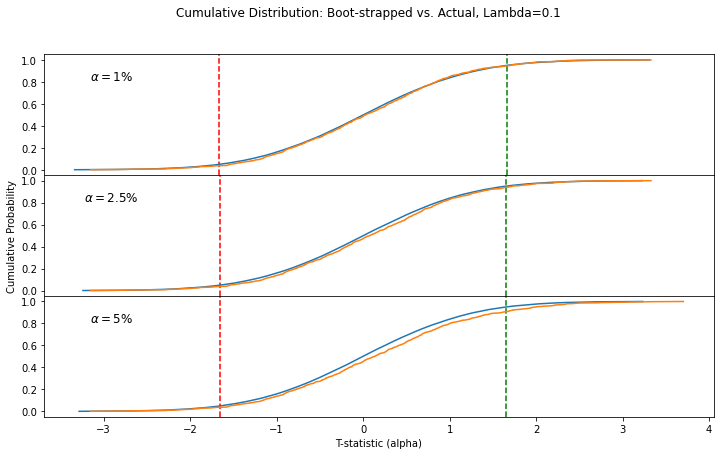

In [22]:
plot1a

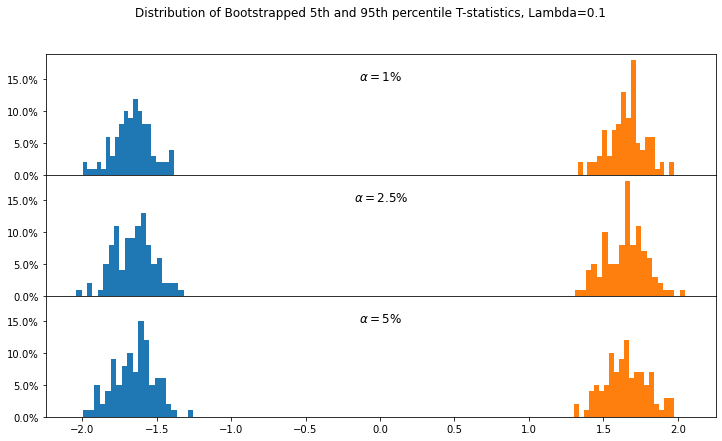

In [23]:
plot1b

In [27]:
plot2a, plot2b=plotr(.25)

In [28]:
plot3a, plot3b=plotr(.5)

In [29]:
plot4a, plot4b=plotr(.75)

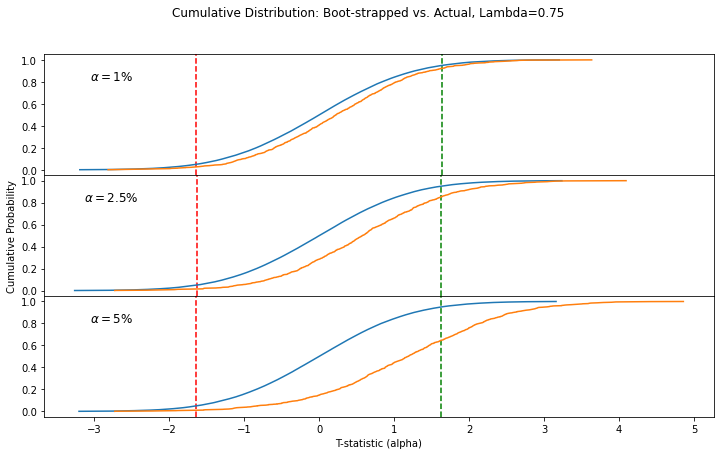

In [34]:
plot4a

That concludes the required analyses.  In the rest of the notebook I simply write the results to a latex file, using functions in ```'functionsByAnthony.py'```


//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [109]:
#Open the latex output file
tabcount=1
figcount=1
latexopen("PS2.tex", 1)
def ctab():
    global tabcount
    tabcount=tabcount+1
    return
def cfig():
    global figcount
    figcount=figcount+1
    return

latexwrite("PS2.tex",
"\\textbf{Part 1 - No Skilled Funds} \\\\", pure=True)

tavgrank.index=[""]*1000
tavgrank["Tstat"]=tavgrank["Tstat"].apply(lambda x: round(x,2))

latexwrite("PS2.tex", "Table "+str(tabcount), "The table depicts the average alpha T-statistic at each rank (1-15 and 985-100) across 100 "+
          "boot-stapped time series, constructed so that the true alpha is equal to 0 for all funds.")
latextable(round(tavgrank[(tavgrank["Rank"]>=985)|(tavgrank["Rank"]<=15)],2),"PS2.tex", escape=False, newpage=False,
           title="Average T-statistic across bootstrap runs, by rank")
ctab()

ptiles.index=[""]*1

latexwrite("PS2.tex", "Table "+str(tabcount), "The table depicts the average 95th and 5th alpha T-statistic across 100 "+
          "boot-stapped time series, constructed so that the true alpha is equal to 0 for all funds.")

latextable(ptiles,"PS2.tex", escape=False, newpage=True,
           title="Average 95th and 5th percentile T-statistic across bootstrap runs")
ctab()

latexwrite("PS2.tex", "Figure "+str(figcount), "Data are generated such that there are no truly skilled funds. "+
"The figure shows the CDF of alpha T-statistics, estimated using bootstrapped (orange) and actual (blue) data. "+
"95th and 5th bootsrap percentiles are given by the green and red dashed lines, respectively.  "
)
latexplot(plot1, "PS2.tex", "plot1", '1cm', scale=1.2/1.2)
cfig()
latexwrite("PS2.tex", "Figure "+str(figcount), "Data are generated such that there are no truly skilled funds. "+
"The second figure shows the distributions of estimated 95th (orange) and 5th (blue) percentile alpha T-statistics"+
" across bootstrap samples."
)


#latexwrite("PS2.tex", "Figure "+str(figcount), "The figure below depicts the distribution of simulated alpha estimates. "+
#    "Returns are simulated such that a fraction $\\lambda$ of the funds/returns are truly skilled ($\\alpha =5$\% per annum).")
latexplot(plot2, "PS2.tex", "plot2", '1cm', scale=1.1/1.2)
cfig()

latexwrite("PS2.tex",
"\\textbf{Part 2 - Some Skilled Funds} \\\\", pure=True)

latexwrite("PS2.tex", "Figure "+str(figcount), "Figures 3-6 show the cumulative distributions of estimated alpha T-statistics at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively.  95th and 5th bootsrap percentiles are given by the green and red dashed lines, respectively. "+
"The CDF of alpha T-statistics is estimated using bootstrapped (orange) and actual (blue) data. "+
           " In the below, $\\lambda=.1$."
 )
latexplot(plot1a, "PS2.tex", "plot1a", '0cm', scale=.7)
cfig()
latexwrite("PS2.tex", "Figure "+str(figcount),"Figures 3-6 show the cumulative distributions of estimated alpha T-statistics at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively.  95th and 5th bootsrap percentiles are given by the green and red dashed lines, respectively. "+
"The CDF of alpha T-statistics is estimated using bootstrapped (orange) and actual (blue) data. "+
           " In the below, $\\lambda=.25$.")
latexplot(plot2a, "PS2.tex", "plot2a", '0cm', scale=.7)
cfig()
latexwrite("PS2.tex", "Figure "+str(figcount), "Figures 3-6 show the cumulative distributions of estimated alpha T-statistics at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively.  95th and 5th bootsrap percentiles are given by the green and red dashed lines, respectively. "+
"The CDF of alpha T-statistics is estimated using bootstrapped (orange) and actual (blue) data. "+
           " In the below, $\\lambda=.5$.")
latexplot(plot3a, "PS2.tex", "plot3a", '0cm', scale=.7)
cfig()
latexwrite("PS2.tex", "Figure "+str(figcount), "Figures 3-6 show the cumulative distributions of estimated alpha T-statistics at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively.  95th and 5th bootsrap percentiles are given by the green and red dashed lines, respectively. "+
"The CDF of alpha T-statistics is estimated using bootstrapped (orange) and actual (blue) data. "+
           " In the below, $\\lambda=.75$.")
latexplot(plot4a, "PS2.tex", "plot4a", '0cm', scale=.7)
cfig()

latexwrite("PS2.tex", "Figure "+str(figcount), "Figures 7-10 show the distributions of estimated 95th (orange) and 5th (blue) percentile alpha T-statistics "+
"across bootstrap runs at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively. "+
" In the below, $\\lambda=.1$.")
latexplot(plot1b, "PS2.tex", "plot1b", '0cm', scale=.7)
cfig()
latexwrite("PS2.tex", "Figure "+str(figcount), "Figures 7-10 show the distributions of estimated 95th (orange) and 5th (blue) percentile alpha T-statistics "+
"across bootstrap runs at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively. "+
" In the below, $\\lambda=.25$.")
latexplot(plot2b, "PS2.tex", "plot2b", '0cm', scale=.7)
cfig()
latexwrite("PS2.tex", "Figure "+str(figcount), "Figures 7-10 show the distributions of estimated 95th (orange) and 5th (blue) percentile alpha T-statistics "+
"across bootstrap runs at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively. "+
" In the below, $\\lambda=.5$.")
latexplot(plot3b, "PS2.tex", "plot3b", '0cm', scale=.7)
cfig()
latexwrite("PS2.tex", "Figure "+str(figcount), "Figures 7-10 show the distributions of estimated 95th (orange) and 5th (blue) percentile alpha T-statistics "+
"across bootstrap runs at each of four levels of lambda (.1, .25, .5, .75), "+
"the fraction of truly skilled funds.  In each figure, lambda is given in the title.  For each lambda, the first panel "+
"conducts the procedure so that the true alpha of the underlying distribution is 1\%.  The second and third use alpha =2.5\% and"+
" 5\%, respectively. "+
" In the below, $\\lambda=.75$.")
latexplot(plot4b, "PS2.tex", "plot4b", '0cm', scale=.7)
cfig()

latexclose("PS2.tex")

#compile command: pdflatex -pdf PS1.tex